## Factor Creation and Decoding of the Deribit Exchange

This is an implmentation of algorithm 1 from Cohen, S. N., Reisinger, C., and Wang, S. (2023a). Arbitrage-free neural-sde market models. Applied Mathematical
Finance, 30(1):1–46.  

Creates arbitrage free low dimensional representation of the entire options book, or in this case exchange, of Deribit. 

This is a modulurised version, will likely to be incorporated into .py scripts for cleaner importing and implementation

In [182]:
# Algorithm 1 (Factor Decoding) — Exact, end‑to‑end implementation
# ----------------------------------------------------------------
# Dependencies:
#   pip install numpy pandas pyarrow scikit-learn cvxpy osqp scipy matplotlib pybobyqa torch torchsde
# (torchsde not used here but generally part of the project)

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from dataclasses import dataclass
from typing import Dict, Tuple, Optional

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import cvxpy as cp
import scipy.sparse as sp
from scipy.interpolate import SmoothBivariateSpline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pybobyqa


# =========================
# 0) IO + Cleaning (Deribit)
# =========================

def read_parquet(file_path: str) -> pd.DataFrame:
    return pq.read_table(file_path).to_pandas()

def clean_deribit(df: pd.DataFrame, reference_date="2025-01-30", r=0.0, q=0.0) -> pd.DataFrame:
    """
    - Splits instrument_name into asset/expiry/strike/type
    - Builds τ (in years, 365*24*3600 continuous trading)
    - Uses Deribit mid_price which is *already quoted in units of the underlying*.
      We convert to normalized price c = C/F. Since mid_price = C/S, then:
          c = (C/F) = (C/S) * (S/F) = mid_price * exp(-(r - q) * τ).
    """
    df = df.copy()
    df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)
    df['expiry'] = pd.to_datetime(df['expiry'])
    ref = pd.to_datetime(reference_date)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms',errors='coerce')
    df['tau'] = np.maximum((df['expiry'] - df['timestamp']).dt.total_seconds() / (365.25*24*3600), 0.0)

    # Only calls with positive USD volume (to bias toward liquid quotes)
    df = df[(df['option_type'] == 'C') & (df['stats_volume_usd'] > 0)]

    # numeric strike, forward, log‑moneyness
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')
    # mid_price already in units of underlying (C/S)
    df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2.0

    # forward and normalized call price c = C/F
    df['F'] = df['underlying_price'] * np.exp((r - q) * df['tau'])
    df['m'] = np.log(df['strike'] / df['F'])
    df['c_norm'] = df['mid_price'] * np.exp(-(r - q) * df['tau'])  # (C/S)*S/F = C/F

    # Timestamps to pandas datetime (Deribit is ms since epoch typically)
    if np.issubdtype(df['timestamp'].dtype, np.number):
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Drop nonsense
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['tau', 'm', 'c_norm', 'underlying_price'])
    return df


# =========================
# 1) Lattice construction
# =========================

@dataclass
class Lattice:
    nn: NearestNeighbors
    nodes: np.ndarray      # shape (N, 2) with columns [tau, m]
    tau_grid: np.ndarray   # shape (n_tau,)
    m_grid: Dict[float, np.ndarray]  # tau -> array of m’s on that row

def build_lattice_grid(df: pd.DataFrame, n_tau=5, n_m=5, random_state=0) -> Lattice:
    """
    Learn a sorted τ‑grid via KMeans on τ (unique), then robust m‑grid (per τ) via percentiles.
    Build nodes (Cartesian product of each τ row’s m‑grid) and a 1‑NN snapper in (τ, m).
    """
    work = df.copy()
    taus_unique = np.sort(work['tau'].unique()).reshape(-1, 1)
    km = KMeans(n_clusters=n_tau, random_state=random_state).fit(taus_unique)

    centers = km.cluster_centers_.flatten()
    order = np.argsort(centers)
    tau_grid = centers[order]

    # Relabel to sorted
    raw_lab = km.predict(work[['tau']].values)
    old2new = {old: new for new, old in enumerate(order)}
    work['tau_cluster'] = np.array([old2new[l] for l in raw_lab], dtype=int)

    # m‑grid per τ (robust 1–99 percentiles)
    m_grid: Dict[float, np.ndarray] = {}
    for i, τ in enumerate(tau_grid):
        sub = work[work['tau_cluster'] == i]
        if len(sub) == 0:
            lo, hi = np.percentile(work['m'], [1, 99])
        else:
            lo, hi = np.percentile(sub['m'], [1, 99])
        m_grid[τ] = np.linspace(lo, hi, n_m)

    # nodes (τ, m) and NN
    nodes = np.vstack([[τ, m] for τ in tau_grid for m in m_grid[τ]])
    nn = NearestNeighbors(n_neighbors=1).fit(nodes)
    return Lattice(nn=nn, nodes=nodes, tau_grid=tau_grid, m_grid=m_grid)

def apply_lattice_train(df: pd.DataFrame, lat: Lattice, top_K=50, fill_method="linear"):
    """
    Train-only version:
      - snap to nodes
      - keep most liquid per (t, node)
      - choose top_K nodes by frequency (train only)
      - return train lattice + the frozen train_keep_idx for later reuse
    """
    pts = df[['tau','m']].values
    idx = lat.nn.kneighbors(pts, return_distance=False)[:,0]

    tmp = df.assign(node_idx=idx)
    best = (tmp.sort_values('stats_volume_usd', ascending=False)
               .drop_duplicates(['timestamp','node_idx']))
    top_nodes = (best['node_idx'].value_counts().nlargest(top_K).index.to_numpy())

    C_sparse = (best[best['node_idx'].isin(top_nodes)]
                .pivot_table(index='timestamp', columns='node_idx', values='c_norm')
                .sort_index())

    # Make sure columns are exactly the top_nodes, in that order
    C_sparse = C_sparse.reindex(columns=top_nodes)

    # Time-wise fill (train-only)
    C = (C_sparse.interpolate(method=fill_method, axis=0).ffill().bfill())

    nodes_sub = lat.nodes[top_nodes]
    tau_sub   = np.unique(nodes_sub[:,0])
    m_sub     = {float(t): np.sort(nodes_sub[nodes_sub[:,0]==t,1]) for t in tau_sub}

    return C, nodes_sub, tau_sub, m_sub, top_nodes  # <-- keep_idx to reuse


def apply_lattice_test(df: pd.DataFrame, lat: Lattice, train_keep_idx, fill_method="linear"):
    """
    Test-only version that REUSES the train mask (train_keep_idx).
    Does not re-select columns. Ensures identical column order to train.
    """
    pts = df[['tau','m']].values
    idx = lat.nn.kneighbors(pts, return_distance=False)[:,0]

    tmp = df.assign(node_idx=idx)
    best = (tmp.sort_values('stats_volume_usd', ascending=False)
               .drop_duplicates(['timestamp','node_idx']))

    # Pivot on ALL nodes seen, then reindex to train_keep_idx
    C_sparse = (best.pivot_table(index='timestamp', columns='node_idx', values='c_norm')
                     .sort_index())

    # Force identical columns (same nodes, same order) as train
    C_sparse = C_sparse.reindex(columns=train_keep_idx)

    # Interpolate within TEST only (no leakage)
    C = (C_sparse.interpolate(method=fill_method, axis=0).ffill().bfill())

    nodes_sub = lat.nodes[train_keep_idx]
    tau_sub   = np.unique(nodes_sub[:,0])
    m_sub     = {float(t): np.sort(nodes_sub[nodes_sub[:,0]==t,1]) for t in tau_sub}

    return C, nodes_sub, tau_sub, m_sub


# ====================================
# 2) Static no‑arbitrage constraints A
# ====================================

def build_noarb_constraints(nodes: np.ndarray,
                            tau_grid: np.ndarray,
                            m_grid: Dict[float, np.ndarray],
                            tau_mono_mode: str = "interp",   # "interp" or "exact"
                            allow_extrapolate: bool = False, # if True, clamp at ends
                            eps: float = 1e-12
                           ) -> Tuple[sp.csr_matrix, np.ndarray]:
    """
    Constraints on c = C/F (normalized call):
      (i)   monotone in τ (interpolated or exact): c(τ_{i+1}, ·) >= c(τ_i, ·)
      (ii)  monotone in m (decreasing in strike): c(m_j) - c(m_{j+1}) >= 0
      (iii) convex in K (use x = e^m), discrete curvature >= 0
      (iv)  bounds: 0 <= c <= 1, and c >= (1 - e^m)_+

    Parameters
    ----------
    tau_mono_mode : "interp" (default) uses linear interpolation on the τ_{i+1} row
                    to evaluate at m-points of τ_i; "exact" uses exact m matches only.
    allow_extrapolate : if True, when an m0 is outside [min(m_{τ1}), max(m_{τ1})],
                        we clamp to the nearest segment (α is clipped to [0,1]).
    """
    n = nodes.shape[0]
    rows, cols, data, b = [], [], [], []
    k = 0

    # Fast index map: (τ, m) -> node index
    idx_map: Dict[float, Dict[float, int]] = {}
    for idx, (τv, mv) in enumerate(nodes):
        τf, mf = float(τv), float(mv)
        d = idx_map.get(τf)
        if d is None:
            d = {}
            idx_map[τf] = d
        d[mf] = idx

    # ----------------------------
    # (i) τ-monotonicity block
    # ----------------------------
    if tau_mono_mode not in ("interp", "exact"):
        raise ValueError("tau_mono_mode must be 'interp' or 'exact'.")

    for i in range(len(tau_grid) - 1):
        τ0, τ1 = float(tau_grid[i]), float(tau_grid[i+1])
        m0s = np.sort(np.asarray(m_grid[τ0], float))
        m1s = np.sort(np.asarray(m_grid[τ1], float))

        if tau_mono_mode == "exact":
            # Only identical m between rows (usually empty if grids were built independently)
            common_ms = sorted(set(m0s).intersection(set(m1s)))
            for m0 in common_ms:
                k0 = idx_map[τ0][float(m0)]
                k1 = idx_map[τ1][float(m0)]
                # c(τ1,m) - c(τ0,m) >= 0
                rows += [k, k]; cols += [k1, k0]; data += [1.0, -1.0]; b.append(0.0); k += 1

        else:
            # Interpolated row τ1 at each m0 from row τ0:
            # α*c(τ1,mL) + (1-α)*c(τ1,mR) - c(τ0,m0) >= 0
            for m0 in m0s:
                # locate bracketing indices in m1s
                j = int(np.searchsorted(m1s, m0))
                if j == 0 or j == len(m1s):
                    if not allow_extrapolate:
                        continue  # skip out-of-range m0
                    # clamp to nearest segment
                    if j == 0:
                        j = 1
                    else:
                        j = len(m1s) - 1

                mL, mR = float(m1s[j-1]), float(m1s[j])
                denom = max(mR - mL, eps)
                α = (mR - float(m0)) / denom  # α in [0,1] inside; may go outside if extrapolating
                if allow_extrapolate:
                    α = float(np.clip(α, 0.0, 1.0))

                # node indices
                k0 = idx_map[τ0][float(m0)]
                kL = idx_map[τ1][mL]
                kR = idx_map[τ1][mR]

                # add row: α*c(τ1,mL) + (1-α)*c(τ1,mR) - c(τ0,m0) >= 0
                rows += [k, k, k]; cols += [kL, kR, k0]; data += [α, (1.0 - α), -1.0]; b.append(0.0); k += 1

    # ----------------------------
    # (ii) m-monotonicity block
    # ----------------------------
    for τ in map(float, tau_grid):
        ms = np.sort(np.asarray(m_grid[τ], float))
        for j in range(len(ms) - 1):
            m0, m1 = float(ms[j]), float(ms[j+1])
            k0 = idx_map[τ][m0]
            k1 = idx_map[τ][m1]
            # c(τ,m0) - c(τ,m1) >= 0
            rows += [k, k]; cols += [k0, k1]; data += [1.0, -1.0]; b.append(0.0); k += 1

    # ----------------------------
    # (iii) convexity in K (x = e^m)
    # ----------------------------
    for τ in map(float, tau_grid):
        ms = np.sort(np.asarray(m_grid[τ], float))
        xs = np.exp(ms)
        for j in range(1, len(ms) - 1):
            mL, mM, mR = float(ms[j-1]), float(ms[j]), float(ms[j+1])
            kL = idx_map[τ][mL]
            kM = idx_map[τ][mM]
            kR = idx_map[τ][mR]
            dxL = xs[j]   - xs[j-1]
            dxR = xs[j+1] - xs[j]
            a = 1.0 / max(dxL, eps)
            c = 1.0 / max(dxR, eps)
            b_mid = -(a + c)
            # a*c(τ,mL) + b_mid*c(τ,mM) + c*c(τ,mR) >= 0
            rows += [k, k, k]; cols += [kL, kM, kR]; data += [a, b_mid, c]; b.append(0.0); k += 1

    # Base matrix for shape constraints
    A0 = sp.csr_matrix((data, (rows, cols)), shape=(k, n)) 

    # ----------------------------
    # (iv) Bounds
    # ----------------------------
    A_ub = -sp.eye(n, format='csr'); b_ub = -np.ones(n)  # c <= 1  ->  -I c >= -1
    A_lb =  sp.eye(n, format='csr')                      # c >= lower
    lower = np.maximum(0.0, 1.0 - np.exp(nodes[:, 1]))
    b_lb  = lower

    A = sp.vstack([A0, A_ub, A_lb], format='csr')
    b = np.concatenate([np.zeros(k), b_ub, b_lb]).astype(float)
    return A, b

# def build_noarb_constraints(nodes, tau_grid, m_grid):
#     meta = []  # per-row: dict(type=..., idx=..., tau=..., m=..., etc.)
#     rows, cols, data, b = [], [], [], []
#     k = 0

#     # τ-monotone
#     for i in range(len(tau_grid)-1):
#         τ0, τ1 = tau_grid[i], tau_grid[i+1]
#         # identical m across rows now that we made lattice rectangular
#         ms = m_grid[τ0]
#         for m in ms:
#             k0 = np.where((np.isclose(nodes[:,0],τ0))&(np.isclose(nodes[:,1],m)))[0][0]
#             k1 = np.where((np.isclose(nodes[:,0],τ1))&(np.isclose(nodes[:,1],m)))[0][0]
#             rows += [k,k]; cols += [k1,k0]; data += [1.0,-1.0]; b.append(0.0)
#             meta.append(dict(kind="tau_mono", tau0=float(τ0), tau1=float(τ1), m=float(m), node_idx=(k0,k1)))
#             k += 1

#     # m-monotone
#     for τ in tau_grid:
#         ms = np.sort(m_grid[τ])
#         for j in range(len(ms)-1):
#             m0, m1 = ms[j], ms[j+1]
#             k0 = np.where((np.isclose(nodes[:,0],τ))&(np.isclose(nodes[:,1],m0)))[0][0]
#             k1 = np.where((np.isclose(nodes[:,0],τ))&(np.isclose(nodes[:,1],m1)))[0][0]
#             rows += [k,k]; cols += [k0,k1]; data += [1.0,-1.0]; b.append(0.0)
#             meta.append(dict(kind="m_mono", tau=float(τ), m0=float(m0), m1=float(m1), node_idx=(k0,k1)))
#             k += 1

#     # convexity in K (x = e^m)
#     for τ in tau_grid:
#         ms = np.sort(m_grid[τ]); xs = np.exp(ms)
#         for j in range(1, len(ms)-1):
#             kL = np.where((np.isclose(nodes[:,0],τ))&(np.isclose(nodes[:,1],ms[j-1])))[0][0]
#             kM = np.where((np.isclose(nodes[:,0],τ))&(np.isclose(nodes[:,1],ms[j  ])))[0][0]
#             kR = np.where((np.isclose(nodes[:,0],τ))&(np.isclose(nodes[:,1],ms[j+1])))[0][0]
#             dxL, dxR = xs[j]-xs[j-1], xs[j+1]-xs[j]
#             a, b_mid, c = 1.0/dxL, -(1.0/dxL+1.0/dxR), 1.0/dxR
#             rows += [k,k,k]; cols += [kL,kM,kR]; data += [a,b_mid,c]; b.append(0.0)
#             meta.append(dict(kind="convex", tau=float(τ), mL=float(ms[j-1]), mM=float(ms[j]), mR=float(ms[j+1]),
#                              node_idx=(kL,kM,kR)))
#             k += 1

#     A0 = sp.csr_matrix((data,(rows,cols)), shape=(k, nodes.shape[0]))
#     # bounds
#     n = nodes.shape[0]
#     A_ub = -sp.eye(n, format='csr'); b_ub = -np.ones(n)
#     for i in range(n): meta.append(dict(kind="bound_upper", node_idx=i))
#     A_lb = sp.eye(n, format='csr')
#     lower = np.maximum(0.0, 1.0-np.exp(nodes[:,1]))
#     b_lb = lower
#     for i in range(n): meta.append(dict(kind="bound_lower", node_idx=i, lower=float(lower[i])))

#     A_raw = sp.vstack([A0, A_ub, A_lb], format='csr')
#     b_raw = np.concatenate([np.zeros(k), b_ub, b_lb]).astype(float)
#     return A_raw, b_raw, meta

def project_noarb(A, b, C_interp: pd.DataFrame,
                  nodes: np.ndarray,
                  tau_grid: np.ndarray,
                  m_grid: Dict[float, np.ndarray]) -> pd.DataFrame:
    """
    For each time slice, project c_raw to nearest c under A c >= b, 0 <= c <= 1.
    Solve with OSQP (QP).
    """
    # A, b = build_noarb_constraints(nodes, tau_grid, m_grid)
    n = nodes.shape[0]

    c_raw = cp.Parameter(n)
    c_var = cp.Variable(n)
    constraints = [A @ c_var >= b, c_var >= 0, c_var <= 1]
    obj = cp.Minimize(cp.sum_squares(c_var - c_raw))
    prob = cp.Problem(obj, constraints)

    out = []
    for _, row in C_interp.iterrows():
        x = row.values.astype(float)
        c_raw.value = x
        try:
            prob.solve(solver=cp.OSQP, warm_start=True, eps_abs=1e-6, eps_rel=1e-6, verbose=False)
        except Exception:
            prob.solve(solver=cp.SCS, warm_start=True, eps_abs=1e-5, eps_rel=1e-5, verbose=False)
        if prob.status not in ("optimal", "optimal_inaccurate"):
            out.append(x)
        else:
            out.append(c_var.value)
    out = np.vstack(out)
    return pd.DataFrame(out, index=C_interp.index, columns=C_interp.columns)


# Redundant linear constraint removal via LP tests
def reduce_constraints_geq(A: sp.csr_matrix, b: np.ndarray, tol=1e-8, solver="OSQP"):
    """
    Remove redundant rows from A x >= b using LP tests.

    Returns
    -------
    A_red, b_red, mask_kept  (mask_kept is boolean for rows kept)
    """
    if sp.issparse(A):
        A = A.tocsr()
    else:
        A = sp.csr_matrix(A)

    m, n = A.shape
    b = np.asarray(b, float).reshape(-1)
    assert b.shape[0] == m

    # Convert to <= form:  G x <= h
    G_full = (-A).toarray()
    h_full = -b.copy()

    x = cp.Variable(n)

    mask_kept = np.ones(m, dtype=bool)
    # pre-build problem objects (we’ll swap G,h per test)
    obj = None
    prob = None

    for i in range(m):
        # remove i-th row
        if not mask_kept[i]:
            continue

        rows = np.arange(m) != i
        G = G_full[rows, :]
        h = h_full[rows]

        # Maximize a_i^T x subject to Gx <= h
        ai = A.getrow(i).toarray().ravel()  # original (>=) row
        objective = cp.Maximize(ai @ x)
        constraints = [G @ x <= h]
        prob = cp.Problem(objective, constraints)
        try:
            prob.solve(solver=solver, verbose=False)
        except Exception:
            # fallback
            prob.solve(solver="SCS", verbose=False, eps=1e-5)

        if prob.status not in ("optimal", "optimal_inaccurate"):
            # Couldn’t certify redundancy — keep it
            mask_kept[i] = True
            continue

        val = prob.value
        # If the best achievable a_i^T x is still <= b_i + tol, row i is implied (redundant)
        if val <= b[i] + tol:
            mask_kept[i] = False

    A_red = A[mask_kept]
    b_red = b[mask_kept]
    return A_red.tocsr(), b_red, mask_kept


# =========================================
# 3) Derivatives via C^{1,2} bivariate spline
# =========================================

def compute_derivatives(Csurf: pd.DataFrame,
                        nodes: np.ndarray,
                        k_tau=2, k_m=3, s=1e-8) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit SmoothBivariateSpline(τ, m) per time slice; evaluate ∂_τ C, ∂_m C, ∂²_m C at the nodes.
    """
    τs = nodes[:, 0]
    ms = nodes[:, 1]
    T, N = Csurf.shape
    dC_dtau = np.zeros((T, N))
    dC_dm   = np.zeros((T, N))
    d2C_dm2 = np.zeros((T, N))

    Carr = Csurf.values
    for t in range(T):
        spline = SmoothBivariateSpline(τs, ms, Carr[t], kx=k_tau, ky=k_m, s=s)
        dC_dtau[t] = spline.ev(τs, ms, dx=1, dy=0)
        dC_dm[t]   = spline.ev(τs, ms, dx=0, dy=1)
        d2C_dm2[t] = spline.ev(τs, ms, dx=0, dy=2)
    return dC_dtau, dC_dm, d2C_dm2


# ====================================
# 4) Stage‑0: log‑S SDE → γ_t (price‑vol)
# ====================================

class Stage0LogNet(nn.Module):
    def __init__(self, input_dim, hidden=64, min_sigma=1e-6):
        super().__init__()
        self.min_sigma = min_sigma
        self.f = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh()
        )
        self.mu = nn.Linear(hidden, 1)
        self.ls = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.f(x)
        mu = self.mu(h)
        sigma = torch.exp(self.ls(h)) + self.min_sigma
        return mu, sigma  # σ is annualized

def make_stage0_dataset(spot: np.ndarray, pcs: np.ndarray, dt_years: np.ndarray):
    spot = np.asarray(spot, float).reshape(-1)
    pcs  = np.asarray(pcs,  float)
    assert len(spot) == len(pcs)
    logS = np.log(spot)
    y = (logS[1:] - logS[:-1]).reshape(-1, 1)  # Δlog S
    X = np.hstack([logS[:-1, None], pcs[:-1]])
    dt = np.asarray(dt_years, float).reshape(-1, 1)
    return X, y, dt

def train_stage0(net: nn.Module,
                 X: np.ndarray, y: np.ndarray, dt: np.ndarray,
                 epochs=200, lr=1e-3, batch=512, scale_X=True, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    net.to(device)

    scaler = None
    if scale_X:
        scaler = StandardScaler().fit(X)
        Xn = scaler.transform(X)
    else:
        Xn = X

    X_t = torch.from_numpy(Xn).float().to(device)
    y_t = torch.from_numpy(y).float().to(device)
    dt_t = torch.from_numpy(dt).float().to(device)

    ds = TensorDataset(X_t, y_t, dt_t)
    dl = DataLoader(ds, batch_size=batch, shuffle=True)

    opt = optim.Adam(net.parameters(), lr=lr)
    for _ in range(epochs):
        for xb, yb, dtb in dl:
            mu, sigma = net(xb)
            var = sigma**2 * dtb + (1e-6*dtb + 1e-12)
            resid = yb - mu*dtb
            nll = 0.5 * (resid**2/var + torch.log(var))
            loss = nll.mean()
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()

    net.eval()
    with torch.no_grad():
        mu_all, sigma_all = net(X_t)
        sigma = sigma_all.squeeze().cpu().numpy()
    return scaler, sigma

def sigma_to_gamma(sigma: np.ndarray, S_tm1: np.ndarray) -> np.ndarray:
    sigma = np.asarray(sigma, float).reshape(-1)
    S_tm1 = np.asarray(S_tm1, float).reshape(-1)
    L = min(len(sigma), len(S_tm1))
    return np.maximum(sigma[:L] * S_tm1[:L], 1e-12)


# ====================================
# 5) Build Z field
# ====================================

def build_Z(dC_dtau, dC_dm, d2C_dm2, gamma, drop_last=True):
    Dτ = np.asarray(dC_dtau, float); Dm = np.asarray(dC_dm, float); Dmm = np.asarray(d2C_dm2, float)
    T, N = Dτ.shape
    g = np.asarray(gamma, float).reshape(-1)
    if drop_last:
        L = min(T-1, len(g))
        s2 = (g[:L]**2)[:, None]
        Z = -Dτ[:L] - 0.5*s2*Dm[:L] + 0.5*s2*Dmm[:L]
    else:
        if len(g) < T:
            g_full = np.pad(g, (0, T-len(g)), mode='edge')
        else:
            g_full = g[:T]
        s2 = (g_full**2)[:, None]
        Z = -Dτ - 0.5*s2*Dm + 0.5*s2*Dmm
    return Z


# ====================================
# 6) Factor decoding (Algorithm 1)
# ====================================

def reconstruct_prices(G0, Xi_dyn, G_dyn, Xi_stat, G_stat, Xi_sa=None, G_sa=None):
    C = (np.asarray(G0, float)[None, :]
         + np.asarray(Xi_dyn, float) @ np.asarray(G_dyn, float)
         + np.asarray(Xi_stat, float) @ np.asarray(G_stat, float))
    if Xi_sa is not None and G_sa is not None:
        C = C + np.asarray(Xi_sa, float) @ np.asarray(G_sa, float)
    return C

def count_violations(C: np.ndarray, A: sp.csr_matrix, b: np.ndarray, tol=1e-6) -> int:
    A_ = A.toarray() if sp.issparse(A) else np.asarray(A, float)
    lhs = A_ @ C.T  # (m, T)
    return int((lhs < (b[:, None] - tol)).sum())

def hinge_penalty(C: np.ndarray, A: sp.csr_matrix, b: np.ndarray) -> float:
    """ Σ_t Σ_i max(0, b_i - (A c_t)_i ) """
    A_ = A.toarray() if sp.issparse(A) else np.asarray(A, float)
    viol = b[:, None] - (A_ @ C.T)   # (m, T)
    return np.maximum(viol, 0.0).sum()

def decode_static_arb_hinge(R_sa_train: np.ndarray,         # residual after dyn+stat removal
                            G0: np.ndarray,
                            Recon_sofar: np.ndarray,         # dyn + stat reconstruction
                            A: sp.csr_matrix, b: np.ndarray, # constraints
                            n_sa=2, n_PC=8,
                            lam_rec=1e-3,
                            lam_hinge=10,
                            maxfun=8000,
                            seed=0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Greedy static‑factor decoding:
      For i=1..n_sa:
        - PCA(R_current) → G_sub (n_PC×N), scores ξ_PC (T×n_PC).
        - Optimize unit vector w∈R^{n_PC} to minimize:
              lam_hinge * Hinge( G0 + Recon_sofar + ξw·(wᵀG_sub) ) + lam_rec * ||R_current - ξw·(wᵀG_sub)||_F
        - Update residuals and store factor/shocks.
    Uses derivative‑free BOBYQA on the sphere (implemented via box + normalization).
    """
    rng = np.random.default_rng(seed)
    T, N = R_sa_train.shape
    R = R_sa_train.copy()
    Rhat = Recon_sofar.copy()

    G_sa = np.zeros((n_sa, N))
    Xi_sa = np.zeros((T, n_sa))
    W = np.zeros((n_sa, n_PC))

    A_dense = A.toarray() if sp.issparse(A) else np.asarray(A, float)
    b_vec = np.asarray(b, float).reshape(-1)
    G0r = np.asarray(G0, float)[None, :]

    def objective_factory(G_sub, Xi_PC):
        # return objective over w∈[-1,1]^{n_PC} (we’ll renormalize inside)
        def obj(w):
            w = np.asarray(w, float)
            if np.allclose(w, 0.0):
                return 1e9
            w = w / np.linalg.norm(w)
            G_cand = w @ G_sub            # (N,)
            xi_cand = Xi_PC @ w           # (T,)
            C_cand = G0r + Rhat + np.outer(xi_cand, G_cand)   # (T, N)
            # penalties
            H = hinge_penalty(C_cand, A_dense, b_vec)
            rec = np.linalg.norm(R - np.outer(xi_cand, G_cand))
            return lam_hinge * H + lam_rec * rec
        return obj

    for i in range(n_sa):
        pca = PCA(n_components=n_PC, random_state=seed+i).fit(R)
        G_sub = pca.components_               # (n_PC, N)
        Xi_PC = pca.transform(R)              # (T, n_PC)

        obj = objective_factory(G_sub, Xi_PC)
        w0 = rng.normal(size=n_PC); w0 /= np.linalg.norm(w0)
        lb, ub = -np.ones(n_PC), np.ones(n_PC)

        sol = pybobyqa.solve(obj, w0, bounds=(lb, ub),
                             rhobeg=0.5, rhoend=1e-4,
                             maxfun=maxfun, seek_global_minimum=True, print_progress=False)
        w_opt = sol.x / np.linalg.norm(sol.x)

        G_i  = w_opt @ G_sub
        xi_i = Xi_PC @ w_opt

        # update running residual and reconstruction
        R    = R    - np.outer(xi_i, G_i)
        Rhat = Rhat + np.outer(xi_i, G_i)

        # store
        G_sa[i]   = G_i
        Xi_sa[:, i] = xi_i
        W[i] = w_opt

    return G_sa, Xi_sa, W


# ====================================
# 7) Metrics
# ====================================

def mape(C_true, C_hat, eps=1e-8):
    C_true = np.asarray(C_true, float); C_hat = np.asarray(C_hat, float)
    return np.mean(np.abs(C_true - C_hat) / (np.abs(C_true) + eps))

def psas(C_hat, A, b, tol=1e-3):
    A_ = A.toarray() if sp.issparse(A) else np.asarray(A, float)
    b_ = np.asarray(b, float).reshape(-1)
    lhs = A_ @ np.asarray(C_hat, float).T
    ok = (lhs >= (b_[:, None] - tol)).all(axis=0)
    return 1.0 - ok.mean()

def pda_from_pca(Z, pca_dyn):
    Zc = Z - Z.mean(axis=0, keepdims=True)
    total_var = Zc.var(axis=0, ddof=1).sum()
    explained = pca_dyn.explained_variance_.sum()
    return 1.0 - (explained / total_var)


# ====================================
# 8) Orchestrator (Algorithm 1)
# ====================================

@dataclass
class Algo1Outputs:
    # grids
    nodes_sub: np.ndarray
    tau_sub: np.ndarray
    m_sub: Dict[float, np.ndarray]
    A: sp.csr_matrix
    b: np.ndarray
    # surfaces
    C_train: pd.DataFrame
    C_test: pd.DataFrame
    # derivatives
    dCtau_train: np.ndarray
    dCm_train: np.ndarray
    d2Cm2_train: np.ndarray
    dCtau_test: np.ndarray
    dCm_test: np.ndarray
    d2Cm2_test: np.ndarray
    # stage-0
    pca_price: PCA
    scaler0: Optional[StandardScaler]
    net0: Stage0LogNet
    sigma_train: np.ndarray
    sigma_test: np.ndarray
    gamma_train: np.ndarray
    gamma_test: np.ndarray
    # factors
    G0: np.ndarray
    pca_dyn: PCA
    G_dyn: np.ndarray
    Xi_dyn_train: np.ndarray
    Xi_dyn_test: np.ndarray
    pca_stat: PCA
    G_stat: np.ndarray
    Xi_stat_train: np.ndarray
    Xi_stat_test: np.ndarray
    G_sa: np.ndarray
    Xi_sa_train: np.ndarray
    Xi_sa_test: np.ndarray
    # reconstructions
    C_hat_train: np.ndarray
    C_hat_test: np.ndarray
    # metrics
    MAPE_train: float
    MAPE_test: float
    PDA_train: float
    PSAS_train: float
    PSAS_test: float

def algorithm1_pipeline(
    file_path: str,
    n_tau=5, n_m=5, top_K=50,
    reference_date="2025-01-30", r=0.0, q=0.0,
    d0=15,                         # PCA price components used as features for Stage‑0
    k_tau=2, k_m=3, s_spline=1e-8, # spline smoothness/degree
    dda=3,                         # # dynamic‑arb factors
    dst=2,                         # # statistical‑accuracy factors
    n_sa=2, n_PC_sa=8,             # static‑arb factors and search subspace
    lam_rec=1e-3, lam_hinge=1.0,
    seed=0
) -> Algo1Outputs:

    # --- Load & clean ---
    raw = read_parquet(file_path)
    df  = clean_deribit(raw, reference_date=reference_date, r=r, q=q).sort_values('timestamp')

    # --- Train/Test split by time (80/20) ---
    all_times = df['timestamp'].sort_values().unique()
    i_cut = int(0.8 * len(all_times))
    train_times = all_times[:i_cut]
    test_times  = all_times[i_cut:]

    train_df = df[df['timestamp'].isin(train_times)].copy()
    test_df  = df[df['timestamp'].isin(test_times)].copy()

    # --- Lattice (fit on train), then apply to train/test ---
    lat = build_lattice_grid(train_df, n_tau=n_tau, n_m=n_m, random_state=seed)
    Ci_train, nodes_sub, tau_sub, m_sub, keep_idx = apply_lattice_train(train_df, lat, top_K=top_K)
    Ci_test,  _,         _,      _      = apply_lattice_test(test_df, lat, keep_idx)

    # --- No‑arb projection (static) ---
    A_raw, b_raw = build_noarb_constraints(nodes_sub, tau_sub, m_sub)
    A, b, kept_mask = reduce_constraints_geq(A_raw, b_raw, tol=1e-8, solver="OSQP")
    C_train = project_noarb(A, b, Ci_train, nodes_sub, tau_sub, m_sub)
    C_test  = project_noarb(A, b, Ci_test,  nodes_sub, tau_sub, m_sub)

    # --- Derivatives via spline (train & test) ---
    dCtau_train, dCm_train, d2Cm2_train = compute_derivatives(C_train, nodes_sub, k_tau, k_m, s_spline)
    dCtau_test,  dCm_test,  d2Cm2_test  = compute_derivatives(C_test,  nodes_sub, k_tau, k_m, s_spline)

    # --- Stage‑0: log‑S SDE for γ (price‑vol) ---
    # Align spot sequences with surface timestamps
    spot_train = (train_df.drop_duplicates('timestamp')
                            .set_index('timestamp')
                            .loc[C_train.index, 'underlying_price'].values)
    spot_test  = (test_df.drop_duplicates('timestamp')
                           .set_index('timestamp')
                           .loc[C_test.index,  'underlying_price'].values)

    # time steps (in years)
    sec_per_year = 365*24*3600
    tt_train = pd.to_datetime(C_train.index.values)
    tt_test  = pd.to_datetime(C_test.index.values)
    dt_train = (tt_train[1:] - tt_train[:-1]).total_seconds() / sec_per_year
    dt_test  = (tt_test[1:]  - tt_test[:-1]).total_seconds()  / sec_per_year

    # PCA on prices (for features only)
    pca_price = PCA(n_components=d0, random_state=seed).fit(C_train.values)
    pcs_train = pca_price.transform(C_train.values)[:, :d0]
    pcs_test  = pca_price.transform(C_test.values)[:,  :d0]

    X0, y0, dt0 = make_stage0_dataset(spot_train, pcs_train, dt_train)
    net0 = Stage0LogNet(input_dim=X0.shape[1], hidden=64)
    scaler0, sigma_train = train_stage0(net0, X0, y0, dt0, epochs=200, lr=1e-3, batch=512, scale_X=True)
    # infer on test
    X0t, y0t, dt0t = make_stage0_dataset(spot_test, pcs_test, dt_test)
    X0t_n = scaler0.transform(X0t) if scaler0 is not None else X0t
    with torch.no_grad():
        mu_t, sigma_t = net0(torch.from_numpy(X0t_n).float())
    sigma_test = sigma_t.squeeze().cpu().numpy()

    gamma_train = sigma_to_gamma(sigma_train, S_tm1=spot_train[:-1])
    gamma_test  = sigma_to_gamma(sigma_test,  S_tm1=spot_test[:-1])

    # --- Z field (uses t=0..T-2) ---
    Z_train = build_Z(dCtau_train, dCm_train, d2Cm2_train, gamma_train, drop_last=True)
    Z_test  = build_Z(dCtau_test,  dCm_test,  d2Cm2_test,  gamma_test,  drop_last=True)

    # --- Baseline G0 (price mean over time, train only) ---
    G0 = C_train.mean(axis=0).values

    # --- Dynamic‑arb factors: PCA on Z_train ---
    pca_dyn = PCA(n_components=dda, random_state=seed).fit(Z_train)
    G_dyn = pca_dyn.components_           # (dda, N)
    # Scores for prices: project (C - G0) along G_dyn
    R0_prices_train = C_train.values - G0[None, :]
    R0_prices_test  = C_test.values  - G0[None, :]

    Xi_dyn_train = R0_prices_train @ G_dyn.T
    Xi_dyn_test  = R0_prices_test  @ G_dyn.T

    # --- Peel off dynamic → Statistical (PCA on residual) ---
    R_dda_train = R0_prices_train - Xi_dyn_train @ G_dyn
    pca_stat = PCA(n_components=dst, random_state=seed).fit(R_dda_train)
    G_stat = pca_stat.components_
    Xi_stat_train = R_dda_train @ G_stat.T
    # Test scores
    R_dda_test = R0_prices_test - Xi_dyn_test @ G_dyn
    Xi_stat_test = R_dda_test @ G_stat.T

    # --- Static‑arb decoding with hinge penalty (greedy) ---
    Recon_sofar_train = Xi_dyn_train @ G_dyn + Xi_stat_train @ G_stat
    G_sa, Xi_sa_train, _W = decode_static_arb_hinge(
        R_sa_train=R0_prices_train - Recon_sofar_train,
        G0=G0, Recon_sofar=Recon_sofar_train,
        A=A, b=b,
        n_sa=n_sa, n_PC=n_PC_sa,
        lam_rec=lam_rec, lam_hinge=lam_hinge,
        maxfun=8000, seed=seed
    )
    # Test static scores (project onto the learned static factors via least‑squares)
    # This matches Algorithm 1's “decode factors on train, then score test”
    Xi_sa_test = (R0_prices_test - (Xi_dyn_test @ G_dyn + Xi_stat_test @ G_stat)) @ np.linalg.pinv(G_sa)



    # --- Reconstructions + metrics ---
    C_hat_train = reconstruct_prices(G0, Xi_dyn_train, G_dyn, Xi_stat_train, G_stat, Xi_sa_train, G_sa)
    C_hat_test  = reconstruct_prices(G0, Xi_dyn_test,  G_dyn, Xi_stat_test,  G_stat, Xi_sa_test,  G_sa)

    MAPE_train = mape(C_train.values, C_hat_train)
    MAPE_test  = mape(C_test.values,  C_hat_test)
    PDA_train  = pda_from_pca(Z_train, pca_dyn)
    PSAS_train = psas(C_hat_train, A, b, tol=5e-3)
    PSAS_test  = psas(C_hat_test,  A, b, tol=5e-3)

    return Algo1Outputs(
        nodes_sub=nodes_sub, tau_sub=tau_sub, m_sub=m_sub, A=A, b=b,
        C_train=C_train, C_test=C_test,
        dCtau_train=dCtau_train, dCm_train=dCm_train, d2Cm2_train=d2Cm2_train,
        dCtau_test=dCtau_test,   dCm_test=dCm_test,   d2Cm2_test=d2Cm2_test,
        pca_price=pca_price, scaler0=scaler0, net0=net0,
        sigma_train=sigma_train, sigma_test=sigma_test,
        gamma_train=gamma_train, gamma_test=gamma_test,
        G0=G0, pca_dyn=pca_dyn, G_dyn=G_dyn,
        Xi_dyn_train=Xi_dyn_train, Xi_dyn_test=Xi_dyn_test,
        pca_stat=pca_stat, G_stat=G_stat,
        Xi_stat_train=Xi_stat_train, Xi_stat_test=Xi_stat_test,
        G_sa=G_sa, Xi_sa_train=Xi_sa_train, Xi_sa_test=Xi_sa_test,
        C_hat_train=C_hat_train, C_hat_test=C_hat_test,
        MAPE_train=MAPE_train, MAPE_test=MAPE_test,
        PDA_train=PDA_train, PSAS_train=PSAS_train, PSAS_test=PSAS_test
    )


# =========================
# Example: run the pipeline
# =========================
if __name__ == "__main__":
    file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
    out = algorithm1_pipeline(
        file_path,
        n_tau=5, n_m=5, top_K=50,
        reference_date="2025-01-30", r=0.0, q=0.0,
        d0=15, k_tau=2, k_m=3, s_spline=1e-8,
        dda=0, dst=1,
        n_sa=1, n_PC_sa=15,
        lam_rec=1e-3, lam_hinge=1.0,
        seed=0
    )
    print("MAPE train:", out.MAPE_train)
    print("MAPE test :", out.MAPE_test)
    print("PDA train :", out.PDA_train)
    print("PSAS train:", out.PSAS_train)
    print("PSAS test :", out.PSAS_test)

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_72232/1271380198.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_72232/1271380198.py:488: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  spline = SmoothBivariateSpline(τs, ms, Carr[t], kx=k_tau, ky=k_m, s=s)


MAPE train: 0.3560212625565521
MAPE test : 0.29553849477037614
PDA train : 1.0
PSAS train: 0.00021267545725223158
PSAS test : 0.0


#### Visualising Factors

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_72232/1195808762.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


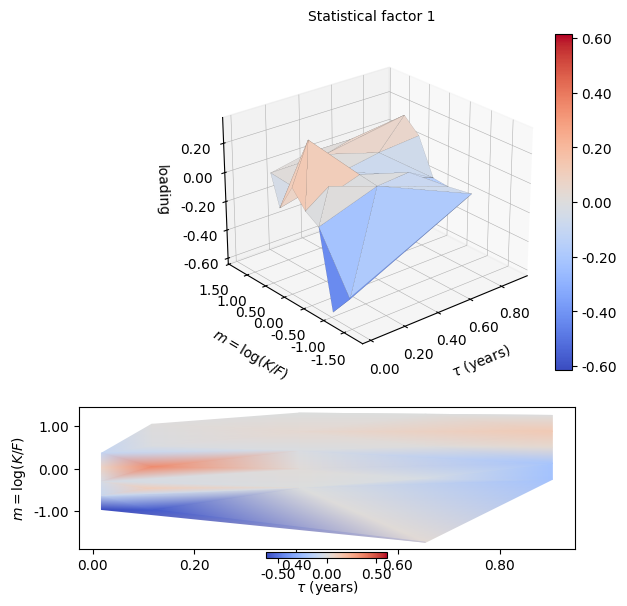

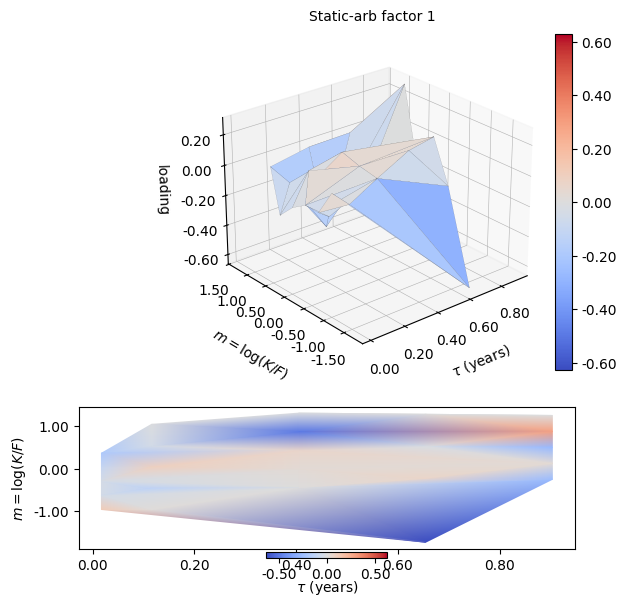

In [183]:
# ============================================
# Visualization: "Figure 7.3.1" style surfaces
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FuncFormatter

def _prepare_nodes(nodes):
    """Return arrays τ, m from nodes (N,2)."""
    tau = nodes[:, 0].astype(float)
    m   = nodes[:, 1].astype(float)
    return tau, m

def _sym_clim(arr, q=0.995):
    """Symmetric color limits based on robust quantile."""
    a = np.asarray(arr, float)
    s = np.quantile(np.abs(a), q)
    s = float(s if s > 0 else np.max(np.abs(a)) + 1e-12)
    return (-s, s)

def _format_tau(x, _pos):
    # show τ in years with 2 decimals
    return f"{x:.2f}"

def _format_m(x, _pos):
    # log-moneyness ticks in plain number, or as % moneyness if you like:
    return f"{x:.2f}"

def _format_loading(x, _pos):
    return f"{x:.2f}"

def _plot_one_surface(ax, tau, m, z,
                      cmap="coolwarm",
                      elev=25, azim=230,
                      linewidth=0.1, antialiased=True,
                      edgecolor="k", alpha=1.0,
                      clim=None, title=None):
    # triangular surface over irregular lattice
    tri = ax.plot_trisurf(tau, m, z,
                          cmap=cmap, linewidth=linewidth,
                          antialiased=antialiased, edgecolor=edgecolor,
                          alpha=alpha)
    if clim is not None:
        tri.set_clim(*clim)
    ax.view_init(elev=elev, azim=azim)
    # axes labels & formatting
    ax.set_xlabel(r"$\tau$ (years)", labelpad=8)
    ax.set_ylabel(r"$m=\log(K/F)$", labelpad=10)
    ax.set_zlabel("loading", labelpad=6)
    ax.xaxis.set_major_formatter(FuncFormatter(_format_tau))
    ax.yaxis.set_major_formatter(FuncFormatter(_format_m))
    ax.zaxis.set_major_formatter(FuncFormatter(_format_loading))
    # gentle background grid feel via thin panes
    ax.xaxis._axinfo["grid"]["linewidth"] = 0.4
    ax.yaxis._axinfo["grid"]["linewidth"] = 0.4
    ax.zaxis._axinfo["grid"]["linewidth"] = 0.4
    if title:
        ax.set_title(title, pad=10, fontsize=10)
    return tri

def _plot_one_heat(ax, tau, m, z, cmap="coolwarm", clim=None):
    # 2-D triangulation heatmap for the same data (top‑down view)
    t = ax.tripcolor(tau, m, z, shading="gouraud", cmap=cmap)
    if clim is not None:
        t.set_clim(*clim)
    ax.set_xlabel(r"$\tau$ (years)")
    ax.set_ylabel(r"$m=\log(K/F)$")
    ax.xaxis.set_major_formatter(FuncFormatter(_format_tau))
    ax.yaxis.set_major_formatter(FuncFormatter(_format_m))
    return t

def _standardize_factor_sign(Gi, tau, m):
    """
    Flip the sign of the factor so that the average loading over small-moneyness,
    medium-τ is positive (purely for visual consistency).
    """
    # pick middle 40% τ and m
    t_lo, t_hi = np.quantile(tau, [0.3, 0.7])
    m_lo, m_hi = np.quantile(m,   [0.3, 0.7])
    mask = (tau >= t_lo) & (tau <= t_hi) & (m >= m_lo) & (m <= m_hi)
    sgn = np.sign(np.nanmean(Gi[mask])) or 1.0
    return Gi * sgn

def plot_factors_figure_731_style(
        out,
        which=("dyn", "stat", "sa"),
        elev=25, azim=230,
        cmap="coolwarm",
        with_heatmaps=True,
        save_prefix=None, dpi=180
    ):
    """
    Parameters
    ----------
    out : Algo1Outputs
        Output from algorithm1_pipeline(...)
    which : tuple
        Any of ("dyn", "stat", "sa") to render dynamic, statistical, static‑arb.
    elev, azim : float
        Camera angles to match the paper figure.
    cmap : str
        Diverging colormap (paper‑like). "coolwarm" works well.
    with_heatmaps : bool
        Add a small 2‑D panel under each 3‑D surface.
    save_prefix : str or None
        If provided, saves PNGs like f"{save_prefix}_dyn1.png", etc.
    """

    tau, m = _prepare_nodes(out.nodes_sub)

    families = []
    if "dyn" in which and out.G_dyn is not None and len(out.G_dyn) > 0:
        families.append(("Dynamic factor", np.asarray(out.G_dyn)))
    if "stat" in which and out.G_stat is not None and len(out.G_stat) > 0:
        families.append(("Statistical factor", np.asarray(out.G_stat)))
    if "sa" in which and out.G_sa is not None and len(out.G_sa) > 0:
        families.append(("Static‑arb factor", np.asarray(out.G_sa)))

    for fam_name, G in families:
        # ensure shape (k, N)
        if G.ndim == 1:
            G = G[None, :]
        # consistent symmetric color limits per family
        clim = _sym_clim(G, q=0.995)

        for i, Gi in enumerate(G, start=1):
            Gi = _standardize_factor_sign(Gi, tau, m)

            # layout: surface (and optional heatmap beneath)
            if with_heatmaps:
                fig = plt.figure(figsize=(6.4, 6.8))
                gs = fig.add_gridspec(2, 1, height_ratios=[3, 1.35], hspace=0.15)
                ax3d = fig.add_subplot(gs[0, 0], projection="3d")
                ax2d = fig.add_subplot(gs[1, 0])
            else:
                fig = plt.figure(figsize=(6.4, 4.8))
                ax3d = fig.add_subplot(111, projection="3d")
                ax2d = None

            title = f"{fam_name} {i}"
            tri = _plot_one_surface(ax3d, tau, m, Gi, cmap=cmap,
                                    elev=elev, azim=azim, clim=clim,
                                    title=title, linewidth=0.05, edgecolor="k")

            cbar = fig.colorbar(tri, ax=ax3d, fraction=0.04, pad=0.03)
            cbar.formatter = FuncFormatter(_format_loading)
            cbar.update_ticks()

            if ax2d is not None:
                t = _plot_one_heat(ax2d, tau, m, Gi, cmap=cmap, clim=clim)
                cbar2 = fig.colorbar(t, ax=ax2d, fraction=0.04, pad=0.02, orientation="horizontal")
                cbar2.formatter = FuncFormatter(_format_loading)
                cbar2.update_ticks()

            # tight layout with small margins (paper‑ish)
            plt.tight_layout()
            if save_prefix:
                fname = f"{save_prefix}_{fam_name.split()[0].lower()}{i}.png"
                plt.savefig(fname, dpi=dpi, bbox_inches="tight")
            plt.show()

# ===== Example usage once you have `out` from algorithm1_pipeline =====
plot_factors_figure_731_style(out,
    which=("dyn","stat","sa"),
    elev=25, azim=230,              # camera angles; tweak if you need to match 1:1
    cmap="coolwarm",                # paper-like diverging colormap
    with_heatmaps=True,
    save_prefix="fig731"            # writes PNGs next to your script
)


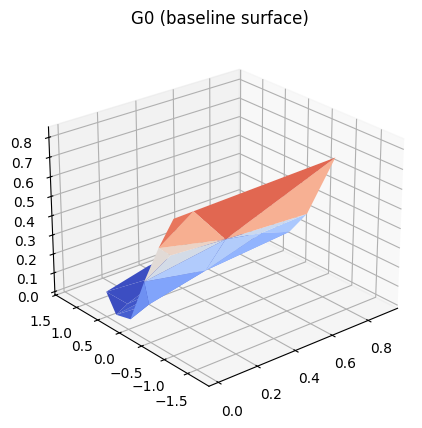

In [184]:
import matplotlib.pyplot as plt
tau, m = out.nodes_sub[:,0], out.nodes_sub[:,1]
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(tau, m, out.G0, cmap="coolwarm", linewidth=0.05)
ax.view_init(elev=25, azim=230)
ax.set_title("G0 (baseline surface)")
plt.show()

In [185]:
import numpy as np
from numpy import sqrt, log
from scipy.special import erf

def _phi(x):  # standard normal pdf
    return np.exp(-0.5*x*x) / np.sqrt(2*np.pi)

def _Phi(x):  # standard normal cdf
    return 0.5*(1.0 + erf(x/np.sqrt(2)))

def bs_call_norm(m, tau, sigma):
    """ Black call normalized: c = C/F, inputs: m=ln(K/F), tau in years, sigma >= 0 """
    m, tau, sigma = np.asarray(m), np.asarray(tau), np.asarray(sigma)
    srt = np.maximum(np.sqrt(np.maximum(tau, 0.0)), 1e-12)
    sigsrt = np.maximum(sigma*srt, 1e-12)
    d1 = (-m)/sigsrt + 0.5*sigsrt
    d2 = d1 - sigsrt
    return _Phi(d1) - np.exp(m)*_Phi(d2)

def bs_vega_norm(m, tau, sigma):
    """ Normalized vega: ∂c/∂σ = φ(d1) * sqrt(tau) """
    m, tau, sigma = np.asarray(m), np.asarray(tau), np.asarray(sigma)
    srt = np.maximum(np.sqrt(np.maximum(tau, 0.0)), 1e-12)
    sigsrt = np.maximum(sigma*srt, 1e-12)
    d1 = (-m)/sigsrt + 0.5*sigsrt
    return _phi(d1) * srt

def implied_vol_from_c_norm(c, m, tau, lo=1e-6, hi=5.0, tol=1e-8, maxit=100):
    """ Brent-like bisection for IV from normalized call price. Vectorized. """
    c = np.asarray(c); m = np.asarray(m); tau = np.asarray(tau)
    lo_arr = np.full_like(c, lo, dtype=float)
    hi_arr = np.full_like(c, hi, dtype=float)
    clo = bs_call_norm(m, tau, lo_arr)
    chi = bs_call_norm(m, tau, hi_arr)
    # clamp target into [clo, chi] to avoid NaNs on degenerate quotes
    target = np.clip(c, clo + 1e-12, chi - 1e-12)
    for _ in range(maxit):
        mid = 0.5*(lo_arr + hi_arr)
        cmid = bs_call_norm(m, tau, mid)
        go_lo = cmid < target
        lo_arr = np.where(go_lo, mid, lo_arr)
        hi_arr = np.where(go_lo, hi_arr, mid)
        if np.max(hi_arr - lo_arr) < tol:
            break
    return 0.5*(lo_arr + hi_arr)

def vega_weighted_mape(C_true, C_hat, nodes, tau_vec=None, power=1.0, eps=1e-8,
                       clip_pct=(1, 99), normalize='global'):
    """
    C_true, C_hat: arrays shape (T, N) of normalized calls (C/F)
    nodes: array shape (N, 2) with columns [tau, m] for each column
    power: weight = vega**power (1.0 is standard; try 0.5 to temper ATM dominance)
    clip_pct: winsorize vegas to de-noise tails
    normalize: 'global' (sum weights = 1 over all T,N) or 'per_time' (weights sum to 1 per row)
    """
    C_true = np.asarray(C_true, float); C_hat = np.asarray(C_hat, float)
    assert C_true.shape == C_hat.shape
    T, N = C_true.shape
    tau = nodes[:, 0]; m = nodes[:, 1]

    # Build per-node (τ,m) arrays
    tauN = np.broadcast_to(tau, (T, N))
    mN   = np.broadcast_to(m,   (T, N))

    # IV per (t,node) from true prices (safer for weights)
    sigma_iv = implied_vol_from_c_norm(C_true, mN, tauN)
    vega = bs_vega_norm(mN, tauN, sigma_iv)

    # Winsorise to avoid exploding ATM short-maturity weights
    lo, hi = np.percentile(vega[~np.isnan(vega)], clip_pct)
    vega = np.clip(vega, lo, hi)

    W = np.power(np.maximum(vega, eps), power)

    if normalize == 'per_time':
        W = W / (W.sum(axis=1, keepdims=True) + eps)
    else:
        W = W / (W.sum() + eps)

    err = np.abs(C_true - C_hat) / (np.abs(C_true) + eps)
    return float(np.sum(W * err))


VW_MAPE_train = vega_weighted_mape(out.C_train.values, out.C_hat_train, out.nodes_sub, power=1.0)
VW_MAPE_test  = vega_weighted_mape(out.C_test.values,  out.C_hat_test,  out.nodes_sub, power=1.0)
print("Vega-weighted MAPE train/test:", VW_MAPE_train, VW_MAPE_test)

Vega-weighted MAPE train/test: 0.11917247599182101 0.12525238973395908


(<Figure size 660x300 with 1 Axes>,
 <Axes: title={'center': '2-factor scores within static no-arb polygon'}, xlabel='$\\xi_s$', ylabel='$\\xi_a$'>)

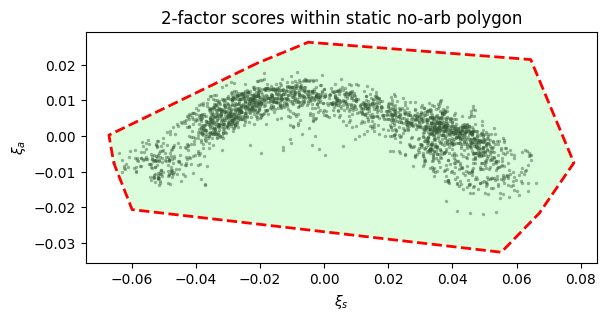

In [188]:
import numpy as np
from scipy.spatial import ConvexHull
import scipy.sparse as sp

def polygon_factor_space(out, tol=1e-12):
    # Two factors only
    G0 = out.G0
    Gs = out.G_stat[0]        # “statistical accuracy” basis
    Ga = out.G_sa[0]          # your single “static-arb” basis

    A = out.A.toarray() if sp.issparse(out.A) else np.asarray(out.A, float)
    b = np.asarray(out.b, float).ravel()

    # Project A c ≥ b through c = G0 + ξ_s Gs + ξ_a Ga
    H = A @ np.vstack([Gs, Ga]).T          # (m,2)
    h = b - A @ G0                         # (m,)

    keep = np.linalg.norm(H, axis=1) > tol
    H, h = H[keep], h[keep]

    # Enumerate pairwise intersections of H_i·ξ = h_i, keep those satisfying all inequalities
    pts = []
    for i in range(H.shape[0]):
        A1,B1 = H[i]; C1 = h[i]
        for j in range(i+1, H.shape[0]):
            A2,B2 = H[j]; C2 = h[j]
            det = A1*B2 - A2*B1
            if abs(det) < 1e-14: 
                continue
            x = (C1*B2 - C2*B1)/det
            y = (A1*C2 - A2*C1)/det
            if np.all(H @ np.array([x,y]) >= h - 5e-3):   # use SAME tol as PSAS
                pts.append([x,y])
    return np.asarray(pts), H, h

import cvxpy as cp

def constrained_scores_2d(C: np.ndarray, out, tol=5e-3):
    # C: (T,N) repaired prices (use out.C_train.values or out.C_test.values)
    G0 = out.G0
    Gs = out.G_stat[0]
    Ga = out.G_sa[0]
    M  = np.column_stack([Gs, Ga])        # (N,2)

    pts, H, h = polygon_factor_space(out, tol=1e-12)

    T, N = C.shape
    xi = np.zeros((T,2))
    z  = cp.Variable(2)
    # Pre-build problem: min ||M z - y||^2  s.t. H z ≥ h
    # We'll update y per time.
    y_param = cp.Parameter(N)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(M @ z - y_param)),
                      [H @ z >= h - tol])  # consistent tolerance
    for t in range(T):
        y_param.value = C[t] - G0
        prob.solve(solver=cp.OSQP, warm_start=True, eps_abs=1e-6, eps_rel=1e-6, verbose=False)
        if prob.status not in ("optimal","optimal_inaccurate"):
            # tiny fallback: unconstrained LS then project to polytope
            z0 = np.linalg.lstsq(M, y_param.value, rcond=None)[0]
            # quick projection: min ||z - z0||^2 s.t. H z ≥ h
            z_var = cp.Variable(2)
            prob2 = cp.Problem(cp.Minimize(cp.sum_squares(z_var - z0)), [H @ z_var >= h - tol])
            prob2.solve(solver=cp.OSQP, warm_start=True, eps_abs=1e-6, eps_rel=1e-6, verbose=False)
            xi[t] = z_var.value
        else:
            xi[t] = z.value
    return xi, pts

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_twofactor_polygon(out, use_test=False):
    C = (out.C_test.values if use_test else out.C_train.values)
    xi, pts = constrained_scores_2d(C, out, tol=5e-3)   # same tol as PSAS
    fig, ax = plt.subplots(figsize=(6.6,3))
    ax.scatter(xi[:,0], xi[:,1], s=6, c="k", alpha=0.45, linewidths=0)

    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        poly = pts[hull.vertices]
        ax.add_patch(Polygon(poly, closed=True, facecolor="#98FB98", edgecolor="none", alpha=0.35))
        cyc = np.vstack([poly, poly[0]])
        ax.plot(cyc[:,0], cyc[:,1], "r--", lw=2.0)
    ax.set_xlabel(r"$\xi_s$"); ax.set_ylabel(r"$\xi_a$")
    ax.set_title("2-factor scores within static no-arb polygon")
    return fig, ax

plot_twofactor_polygon(out, use_test=True)